# Выбор локации для скважины

Допустим, мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
#Импорт библиотек
import pandas as pd
import numpy as np
from scipy import stats as st

#хитмэп корреляции
import os
import seaborn as sns

#операции с выборкой
from sklearn.model_selection import train_test_split

#сохранение модели
import joblib 
from joblib import dump

#классификация
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 

#регрессия
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

#преобразователь масштаба методом стандартизации
from sklearn.preprocessing import StandardScaler

#метрики
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

#подбор параметров
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#построение ROC-кривой
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve 
from sklearn import metrics
from sklearn.metrics import roc_auc_score

#раздел upsampling
from sklearn.utils import shuffle

In [2]:
#Уберем предупреждения:

#D:\installed\anaconda3\envs\praktikum_env_win_new\lib\site-packages\sklearn\utils\fixes.py:223: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.if _joblib.__version__ >= LooseVersion('0.12'):
import warnings
warnings.filterwarnings('ignore')

#SettingWithCopy 
#при записи изменённых признаков в исходный датафрейм (особенности поведения sklearn и pandas)
pd.options.mode.chained_assignment = None

#отключим предупреждением библиотеки sklearn при обучении логистической регрессии, 
#укажем аргумент solver='liblinear' (англ. solver «алгоритм решения»; library linear, «библиотека линейных алгоритмов»)

In [3]:
#загрузим датасет
try:
    df_0 = pd.read_csv('geo_data_0.csv')
    df_1 = pd.read_csv('geo_data_1.csv')
    df_2 = pd.read_csv('geo_data_2.csv')        
except FileNotFoundError:
    df_0 = pd.read_csv('/datasets/geo_data_0.csv')
    df_1 = pd.read_csv('/datasets/geo_data_1.csv')
    df_2 = pd.read_csv('/datasets/geo_data_2.csv')  

In [4]:
#выведем типы признаков данных в таблице
for df in [df_0, df_1, df_2]:
    print(df.dtypes)
    display(df.head())
    df.info()
    df.describe()
    print()

id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB



In [5]:
# 
#for df in [df_0, df_1, df_2]:
#    df.info()
#    df = df.drop(columns=['id'], axis=1)
#    df.info()
#   print()

df_0 = df_0.drop(columns=['id'], axis=1)
df_1 = df_1.drop(columns=['id'], axis=1)
df_2 = df_2.drop(columns=['id'], axis=1)

df_0.info()
df_1.info()
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1 

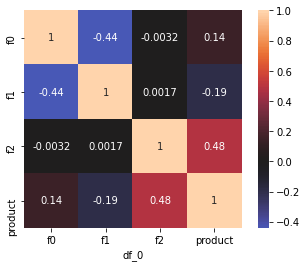

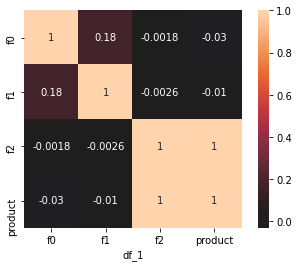

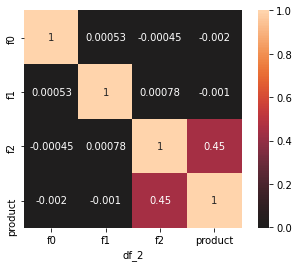

In [6]:
#проверим корреляцию признаков
i=0
for df in [df_0, df_1, df_2]:
    #Numeric columns of the dataset
    numeric_col = ['f0','f1','f2', 'product']
    #Correlation Matrix formation
    corr_matrix = df.loc[:,numeric_col].corr()
    #Using heatmap to visualize the correlation matrix
    plt.show()
    sns.heatmap(df.corr(), annot=True, fmt='.2g', square=True, center= 0)
    plt.xlabel('df_' + str(i))
    i +=1

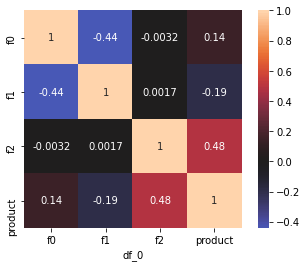

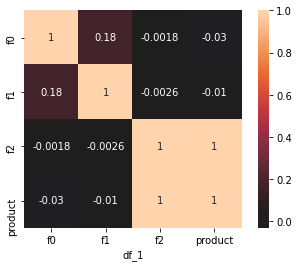

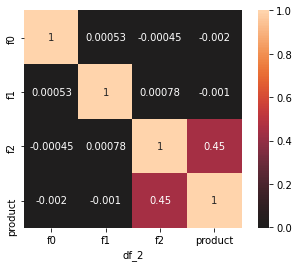

In [7]:
#проверим корреляцию признаков
i=0
for df in [df_0, df_1, df_2]:
    #Numeric columns of the dataset
    numeric_col = ['f0','f1','f2', 'product']
    #Correlation Matrix formation
    corr_matrix = df.loc[:,numeric_col].corr()
    #Using heatmap to visualize the correlation matrix
    plt.show()
    sns.heatmap(df.corr(), annot=True, fmt='.2g', square=True, center= 0)
    plt.xlabel('df_' + str(i))
    i+=1

### Вывод
    -мы удалили столбец id тк не несет важной информации для обучеия модели
    -согласно шкале Чеддока - между продуктом и признаками, наблюдаем    
    --в регионе 0: очень слабую и слабую связь         
    --в регионе 1: очень слабую и очень высокую
    --в регионе 2: очень слабую и слабую связь            

## Обучение и проверка модели

### Разделим данные на обучающую и валидационную выборки в соотношении 75:25.

In [31]:
features_0 = df_0.drop(['product'] , axis=1)
target_0 = df_0['product']

features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
    features_0, target_0, test_size=0.25, random_state=12345)

print('features_0', features_0.shape)
print('target_0', target_0.shape)

print('features_train_0', features_train_0.shape)
print('target_train_0', target_train_0.shape)

print('features_valid_0', features_valid_0.shape)
print('target_valid_0', target_valid_0.shape)

features_0 (100000, 3)
target_0 (100000,)
features_train_0 (75000, 3)
target_train_0 (75000,)
features_valid_0 (25000, 3)
target_valid_0 (25000,)


In [32]:
features_1 = df_1.drop(['product'] , axis=1)
target_1 = df_1['product']

features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=12345)

print('features_1', features_1.shape)
print('target_1', features_1.shape)

print('features_train_1', features_train_1.shape)
print('target_train_1', features_valid_1.shape)

print('features_valid_1', features_train_1.shape)
print('target_valid_1', features_valid_1.shape)

features_1 (100000, 3)
target_1 (100000, 3)
features_train_1 (75000, 3)
target_train_1 (25000, 3)
features_valid_1 (75000, 3)
target_valid_1 (25000, 3)


In [33]:
features_2 = df_2.drop(['product'] , axis=1)
target_2 = df_2['product']

features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=12345)

print('features_2', features_2.shape)
print('target_2', features_2.shape)

print('features_train_2', features_train_2.shape)
print('target_train_2', features_valid_2.shape)

print('features_valid_2', features_train_2.shape)
print('target_valid_2', features_valid_2.shape)

features_2 (100000, 3)
target_2 (100000, 3)
features_train_2 (75000, 3)
target_train_2 (25000, 3)
features_valid_2 (75000, 3)
target_valid_2 (25000, 3)


### Обучите модель и сделаем предсказания на валидационной выборке.
    -Сохраним предсказания и правильные ответы на валидационной выборке.
    -Напечатаем на экране средний запас предсказанного сырья и RMSE модели.

In [34]:
model = LinearRegression()

model.fit(features_train_0, target_train_0)
predictions_valid_0 = model.predict(features_valid_0)


avg_predicted_raw_0 = predictions_valid_0.mean()
print("avg_predicted_raw_0 =", avg_predicted_raw_0)

mse = mean_squared_error(target_valid_0, predictions_valid_0)
print("RMSE =", mse ** 0.5)

avg_predicted_raw_0 = 92.59256778438035
RMSE = 37.5794217150813


In [35]:
model = LinearRegression()

model.fit(features_train_1, target_train_1)
predictions_valid_1 = model.predict(features_valid_1)


avg_predicted_raw_1 = predictions_valid_1.mean()
print("avg_predicted_raw_1 =", avg_predicted_raw_1)

mse = mean_squared_error(target_valid_1, predictions_valid_1)
print("RMSE =", mse ** 0.5)

avg_predicted_raw_1 = 68.728546895446
RMSE = 0.893099286775617


In [36]:
model = LinearRegression()

model.fit(features_train_2, target_train_2)
predictions_valid_2 = model.predict(features_valid_2)


avg_predicted_raw_2 = predictions_valid_2.mean()
print("avg_predicted_raw_2 =", avg_predicted_raw_2)

mse = mean_squared_error(target_valid_2, predictions_valid_2)
print("RMSE =", mse ** 0.5)

avg_predicted_raw_2 = 94.96504596800489
RMSE = 40.02970873393434


### Вывод
    -мы разбили данные на выборки и обучили модель
    -средний запас от 68.72854689544599 до 94.96504596800489 единиц предсказанного сырья, т.е тысяч баррелей
    -RMSE модели от 37.5794217150813 до 0.8930992867756169    

## Подготовка к расчёту прибыли

### Все ключевые значения для расчётов сохраним в отдельных переменных (сохранили выше)

### Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.


    Условия задачи:
    
    Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).    
    При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.    
    Бюджет на разработку скважин в регионе — 10 млрд рублей.    
    При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.    
    После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
      
    Резюмируем: 500точек, 10 000 000 000р на все скважины, 1 баррель 450р, доход с 1 единицы 450 000р, тк 1 единица это 1000 баррелей

In [37]:
points = 500

oilwells = 200 #далее 'ow'
price_1_bar_rub = 450
budget_rub = 10000000000

#стоимость 1 единицы продукта в рублях (1000 баррелей)
price_1_kbar_rub = price_1_bar_rub * 1000

#рассчитаем сколько рублей мы должны получить с одной точки(скважины) в среднем -без убытка
avg_break_even_1_ow_rub = budget_rub/oilwells
print('avg_break_even_1_ow_rub', avg_break_even_1_ow_rub)

#рассчитаем сколько единиц продукта мы должны получить с одной точки(скважины) в среднем -без убытка
avg_break_even_1_ow_unit = avg_break_even_1_ow_rub/ price_1_kbar_rub
print('avg_break_even_1_ow_unit', avg_break_even_1_ow_unit)

avg_break_even_1_ow_rub 50000000.0
avg_break_even_1_ow_unit 111.11111111111111


In [38]:
#рассчитаем сколько в среднем единиц продукта а каждом из регионов
cnt = 0
for df in [df_0, df_1, df_2]:   
    print('регион:', cnt) 
    print('среднее', df['product'].mean())
    print('медиана', df['product'].median())
    print()
    cnt += 1

регион: 0
среднее 92.50000000000001
медиана 91.84997204396296

регион: 1
среднее 68.82500000000002
медиана 57.08562464628662

регион: 2
среднее 95.00000000000004
медиана 94.92561258990247



### Напишем выводы по этапу подготовки расчёта прибыли.
    -мы рассчитали сколько рублей мы должны получить с одной точки(скважины) в среднем -без убытка - 50000000.0 руб
    -111.11111111111111единиц продукта мы должны получить с одной точки(скважины) в среднем -без убытка

## Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
    -Выберем скважины с максимальными значениями предсказаний.
    -Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
    -Рассчитаем прибыль для полученного объёма сырья.

In [75]:
def profit(target, predict, price_1_kbar_rub, budget_rub):
    predict = pd.Series(predict)
    
    predict_sorted = predict.sort_values(ascending=False)
    selected_points = target[predict_sorted.index][:200] #выберем факт. объемы нефти с индексами двухсот макс. предсказаний
    product = selected_points.sum()
    #print(selected_points)
    revenue = product * price_1_kbar_rub
    return revenue - budget_rub

profit(target_0, predictions_valid_0, price_1_kbar_rub, budget_rub)
profit(target_1, predictions_valid_1, price_1_kbar_rub, budget_rub)
profit(target_2, predictions_valid_2, price_1_kbar_rub, budget_rub)

-1259258892.6866302

### Вывод
    -мы написали функцую:
    --выбраkb скважины с максимальными значениями предсказаний.
    --просуммировали целевое значение объёма сырья, соответствующее этим предсказаниям.
    --рассчитали прибыль для полученного объёма сырья.
    
    Предсказания неутешительные, сумма прибыли по всем регионам отрицательная: 
    -1922149005.722169, -4015754052.6666927, -1259258892.6866302

## Посчитаем риски и прибыль для каждого региона


### Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

### Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

In [77]:
state = np.random.RandomState(12345)

for df in [df_0, df_1, df_2]:

    features = df.drop(['product'], axis=1)
    target = df['product']
    
    features_train, features_valid, target_train, target_valid = train_test_split(
         features, target, test_size=0.25, random_state=state)

    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_1 = model.predict(features_valid)


    
    
    target = target_valid.reset_index(drop=True)
    predictions = pd.Series(predictions_1)

    profit_v=[]
    for i in range(1000):
        target_sample = target.sample(500, replace=True, random_state=state)
        predictions_sample = predictions[target_sample.index]
        profit_v.append(profit(target_sample, predictions_sample, price_1_kbar_rub, budget_rub))
    profit_v = pd.Series(profit_v)

    mean_profit = profit_v.mean()
    confidence_interval = (profit_v.quantile(0.025), profit_v.quantile(0.975))
    risk = ((profit_v < 0).mean()* 100, "%")
    print("Средняя прибыль =", mean_profit)
    print("95%-ый доверительный интервал:", confidence_interval)
    print("Риск убытков =", risk)
    print()

Средняя прибыль = 426272370.7738766
95%-ый доверительный интервал: (-126790034.58664788, 983427683.7188535)
Риск убытков = (6.800000000000001, '%')

Средняя прибыль = 509144419.148401
95%-ый доверительный интервал: (103030263.74466248, 948591900.5358982)
Риск убытков = (1.2, '%')

Средняя прибыль = 345891112.8435471
95%-ый доверительный интервал: (-188658819.97242478, 875761830.8790764)
Риск убытков = (9.8, '%')



### Напишем выводы: предложим регион для разработки скважин и обоснуем выбор.
    Лучший регион по всем параметрам - регион_1 
    Средняя прибыль = 509144419.148401
    95%-ый доверительный интервал: (103030263.74466248, 948591900.5358982)
    Риск убытков = (1.2, '%')

## Общий вывод
    В полученных датасетах выявили связь объема продукта с признаками, сила связи доходит до очень высокой
    На основе расчетов и выбора лучших показателей можем выделить регион_1
 

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: модели обучены и проверены
    - [ ]  Данные корректно разбиты на обучающую и валидационную выборки
    - [ ]  Модели обучены, предсказания сделаны
    - [ ]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [ ]  На экране напечатаны результаты
    - [ ]  Сделаны выводы
- [ ]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [ ]  Для всех ключевых значений созданы константы Python
    - [ ]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [ ]  По предыдущему пункту сделаны выводы
    - [ ]  Написана функция расчёта прибыли
- [ ]  Выполнен шаг 4: посчитаны риски и прибыль
    - [ ]  Проведена процедура *Bootstrap*
    - [ ]  Все параметры бутстрепа соответствуют условию
    - [ ]  Найдены все нужные величины
    - [ ]  Предложен регион для разработки месторождения
    - [ ]  Выбор региона обоснован